In [1]:
import numpy as np
import pandas as pd
import sqlite3
import os

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from gaussfit import *

## Functions for channel mapping

In [2]:
def readSqlitedb(database="/cvmfs/icarus.opensciencegrid.org/products/icarus/icarus_data/v09_62_00/icarus_data/database/ChannelMapICARUS.db", table="pmt_placements"):

    # Read sqlite query results into a pandas DataFrame
    con = sqlite3.connect(database)
    df = pd.read_sql_query("SELECT * from {}".format(table), con)

    con.close()

    return df

def channel_to_PMTid(channels):
    
    geo = readSqlitedb()
    
    if np.isscalar(channels):
        pmt_id = geo[geo.channel_id==channels].pmt_id.values[0]
        return pmt_id
    else:
        pmt_ids = [ geo[geo.channel_id==ch].pmt_id.values[0] for ch in channels ] 
        return pmt_ids
    
def PMTid_to_channel(pmt_ids):
    
    geo = readSqlitedb()
    
    if np.isscalar(pmt_ids):
        channel = geo[geo.pmt_id==pmt_ids].channel_id.values[0]
        return channel
    else:
        channels = [ geo[geo.pmt_id==pmt].channel_id.values[0] for pmt in pmt_ids ] 
        return channels

## Functions for data loading

In [3]:
# Get the timestamp
def getTimestamp(file):
    
    buff=file.split('_')
    timestamp = int(buff[-1].split('.')[0])
    
    return timestamp
    

# Load a single file
def getDataFrame(file, offchs, timeseries=True):
   
    df=pd.read_csv(file, sep=',')
    
    # remove list of PMTs that are off
    df= df[~df['pmt'].isin(offchs)]
    
    if timeseries:
        df["timestamp"] = getTimestamp(file)
        df.set_index("timestamp", inplace=True)
    
    return df
    
# Load a dataframe dictionary having timestamp as key   
def dataLoaderDict( offPMTs, interval=(1610067905, 1637788392), sourcedir = "../calibrationdb/"):

    data = { getTimestamp(file) : getDataFrame(sourcedir+file, offPMTs, False) for file in  os.listdir(sourcedir) if ("backgroundphotons" in file and getTimestamp(file)>=interval[0] and getTimestamp(file)<interval[1])}
    data = {key:data[key] for key in sorted(data.keys())}
    return data

############################### DATA IMPORTER FUNCTION ###############################
def dataLoader( offchPMTs, sourcedir = "../calibrationdb/", interval=(1610067905, 1637788392)):
        
    print("Import data in folder{} for interval ({}:{})".format(sourcedir, interval[0], interval[1]))
    
    # Load the data from the fit database
    data = pd.concat([ getDataFrame(sourcedir+file, offchPMTs, True) for file in  os.listdir(sourcedir) if "backgroundphotons" in file ])
    
    # keep data only for the selected interval
    data = data.loc[(data.index>=interval[0]) & (data.index<interval[1])]
    
    # Sort the indeces by time
    data = data.sort_index()
    
    return data

###############################
def get_mean_q(dataDict):
    
    t, q, eq, s, es = [], [], [], [], []
    for tt in dataDict.keys():
        xs, ys, param, eparam  = fitGainsDistribution( dataDict[tt], BINSIZE=0.005, RMIN=0.0, RMAX=1.0, p0=(0.4, 0.04) )
        q.append(param[1])
        t.append(datetime.fromtimestamp(tt))
        eq.append(param[2]) #use sigma as error for mean
        s.append(param[2]/param[1]*100)
        es.append(np.sqrt( np.power(100*eparam[2]/param[1],2) + np.power(100*param[2]/(param[1]*param[1])*eparam[1],2)))
        
    return t, q, eq, s, es

# Plotting

In [4]:
# Define source parameters 
sdir   = "/icarus/data/users/mvicenzi/pmt-calibration/calibrationdb/"

# Import data between December 2022 and December 2023
trange = (1671100000, 1702598400)

offPMTs = [1, 111, 143, 166, 192, 230, 238, 254, 222, 302, 309, 340, 353, 290 ]
offchs = PMTid_to_channel(offPMTs)
print(offchs)

data   = dataLoader( offchs, sdir, interval= trange)
dataDict = dataLoaderDict( offchs, interval= trange, sourcedir = sdir )

[350, 248, 215, 190, 161, 139, 127, 103, 131, 59, 52, 21, 5, 71]
Import data in folder/icarus/data/users/mvicenzi/pmt-calibration/calibrationdb/ for interval (1671100000:1702598400)


## Mean gain

-0.009014367075128815 -2.016749964156643


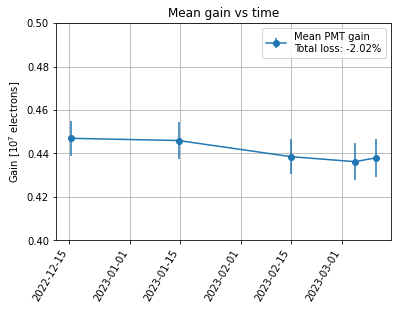

In [5]:
tm, qm, eqm, sm, esm = get_mean_q(dataDict)

diff = qm[-1]-qm[0]
perc = diff/qm[0]*100
print(diff, perc)

plt.errorbar( x=tm, y=qm, yerr=eqm, fmt='o-',label="Mean PMT gain\nTotal loss: {:.2f}%".format(perc))
plt.ylim((0.4,0.5))
#plt.xlabel("Time")
plt.ylabel("Gain [$10^7$ electrons]")
plt.title("Mean gain vs time")
plt.grid()
plt.setp(plt.gca().get_xticklabels(), rotation=60, ha="right")
#plt.tight_layout()
plt.legend()
plt.show()

[1.8053550184680147, 1.9438490871865146, 1.815506179700942, 1.9804619764589777, 2.0018407178006665] [0.018038315827145986, 0.02371834037762456, 0.012257124488675834, 0.02012839566165797, 0.01590147161062389]


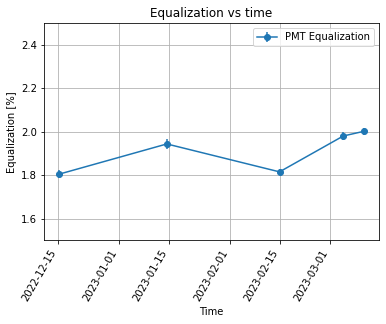

In [6]:
print(sm, esm)
plt.errorbar( x=tm, y=sm, yerr=esm, fmt='o-',label="PMT Equalization")
plt.ylim((1.5,2.5))
plt.xlabel("Time")
plt.ylabel("Equalization [%]")
plt.title("Equalization vs time")
plt.grid()
plt.setp(plt.gca().get_xticklabels(), rotation=60, ha="right")
#plt.tight_layout()
plt.legend()
plt.show()

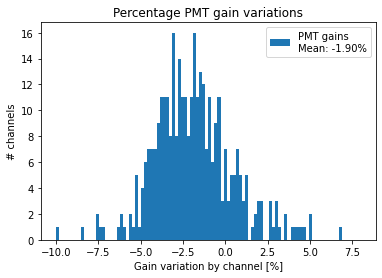

In [7]:
diff = []
for PMT in range(0, 360): #[1, 240]:   
    
        if PMT in offchs:
            continue
    
        df = data[data.pmt==PMT]
        
        # Extract the data of interest.
        q = np.array(df["q"])
        #print(q, q[-1], q[0])
        d = (q[-1]-q[0])/q[0]*100
        #print(d)
        diff.append(d)

plt.hist(diff, bins=100, range=(-10.,8.), histtype='bar', lw=2, label="PMT gains\nMean: {:.2f}%".format(np.mean(diff)))
plt.xlabel("Gain variation by channel [%]")
plt.ylabel("# channels")
plt.title("Percentage PMT gain variations")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))

for PMT in range(0, 360): #[1, 240]:   
    
        if PMT in offchs:
            continue
    
        df = data[data.pmt==PMT]
        
        # Extract the data of interest.
        t = np.array([datetime.fromtimestamp(tt) for tt in df.index])
        q = np.array(df["q"])
        eq = np.array(df["eq"])
        npoints = len(q)
    
        # Make the data plot
        if npoints ==0:
            print("PMT {} has no correct data associated".format(PMT))
            continue
                  
        #label='\n'.join( ['Data PMT %d' % pmt,  
        #              '  Operative voltage: %d V' % voltage, 
        #              '  Number of time points: %d' % npoints])
        out = ax.errorbar( x=t, y=q, yerr=eq, fmt='o-', color="#1f77b4")#, label=label)
        
        
        #legend = fig.legend(fontsize=10, bbox_to_anchor=[1.18, 0.99])
        #legend.get_frame().set_alpha(None)
        fig.tight_layout()

ax.axhline(y=qm[0], color="red", linestyle='dotted', label=tm[0], zorder=10)
ax.axhline(y=qm[-1], color="magenta", linestyle='dotted', label=tm[-1], zorder=10)
plt.xlabel("Time")
plt.ylabel("Gain [10^7 electrons]")
plt.title("PMT gains vs Time")
plt.legend()
plt.show()
                
print("ALL DONE")